[//]: # (Image References)

[image1]: https://user-images.githubusercontent.com/10624937/42135623-e770e354-7d12-11e8-998d-29fc74429ca2.gif "Trained Agent"

# Collaboration and Competition

---

In this notebook, we will explore DDPG and self-play to learn how to play tennis using the Unity ML-Agents environment. This was part of the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

![Trained Agent][image1]

## 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from unityagents import UnityEnvironment

from ddpg_agent import SADDPG, MiADDPG

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Linux/Tennis.x86_64")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


## 3. Approach

In the previous [project](https://github.com/escorciav/drlnd-continuous-control), we saw the DDPG algorithm in practice achieving reaching a moving target (yields high-rewards) while learning continous actions from observations. Interestingly, we employed multiple _independent_ agents collecting a diverse set of experiences. This time, the _Tennis_ environment involves placing two agents interacting with each other as they learn to master the game.

_Shall we use our previous approach?_

That's certainly the most straighforward approach. We can place a single agent to learn the game while playing againts itself i.e. learning through self-play. In other words, we could use the same actor and critic parameters $\theta_\mu, \theta_Q$ for each agent and let them interact (collect experiences) as if they were two different entities.

_Doesn't sound truly multi-agent?_

That's right. Given that we have a unique set of parameters $\theta_\mu, \theta_Q$, this is not a truly multi-agent solution. Nevertheless, there is an additional challenge with respect to other environments, the agent needs to learn as it interacts with itself.

### 3.1 Actor-Critic and hyper-parameters details

For simpliciy and modularity, all the inner details of our actor and critic networks are in this [module](https://github.com/escorciav/drlnd-continuous-control/blob/master/model.py). We used the same hyper-parameter configuration described in the [DDPG paper](https://arxiv.org/pdf/1509.02971.pdf).

For the _Actor_, we use a MLP with a single hidden layer. In practice, we project the state space into a space of 400 dimension through a Linear layer. The size of our hidden layer is 300 dimensions. Finally, our output layer projects the output of our hidden layer into the size of the action space. With the exception of the last linear projection layer, all the others are followed by a ReLU non-linearity. The last linear layer is followed by a `tanh` non-linearity ensuring that the output range fits between $[-1, 1]$ i.e. the admisible values of our actuators.

The _Critic_ network is similar to the _Actor_. The only notable differences are:

- The size of our output layer is reduced to 1 and we remove any non-lineary after it, as it is estimating the value the combined state and action pair.
    
- We fuses the state and action in the "hidden layer" of our network as presented in the DDPG paper.
    
The following figure depicts the details of our Actor adn Critic networks.

![Architecture](https://github.com/escorciav/drlnd-continuous-control/raw/master/data/diagram.png)

_Optimization and exploration and others details_

We update the target networks after each learning steps with a $\tau$ value equal to 1e-3 i.e. after each learning update our target actor-critic networks move closer to the new actor-critics networks by 0.1%. The size of our buffer is 100k experiences and the batch size is 128. The discount factor for future rewards is set 0.99.

As epxloration strategy, we use noise in the action space. In particular, the noise is sampled from [Ornstein-Uhlenbeck process](https://en.wikipedia.org/wiki/Ornstein%E2%80%93Uhlenbeck_process) with $\theta=0.15$, $\sigma=0.2$. In this way, we can add temporally-correlated noise which is of particular interest for continous problems such us our Reacher.

Here, we use the ADAM optimizer learning rates of 1e-3 and 1e-4 for the critic and the actor, respectively. The target actor-critic networks are updated via soft-updates using $\tau=1e-3$

### 3.2 Time of (Agent) learning

Now it's time to train our own agent to solve the environment!

In [5]:
random_seed = 1701
num_episodes = 3500
is_solved_score = 0.5
print_freq = 0.1

#############################################################
# Agent(s) setup
agent = SADDPG(
    state_size=state_size, action_size=action_size,
    random_seed=random_seed)
#############################################################

best_score = -np.inf
scores_window = deque(maxlen=100)
score_episodes, mov_avg_score_episodes = [], []
if print_freq < 1:
    print_freq = max(int(print_freq * num_episodes), 1)

for i_episode in tqdm(range(1, num_episodes + 1)):
    env_info = env.reset(train_mode=True)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    
    while True:
        actions = agent.act(states)
        
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        agent.step(states, actions, rewards, next_states, dones)
        
        scores += env_info.rewards
        states = next_states
        if any(dones):
            break
    
    max_score = scores.max()
    scores_window.append(max_score)
    score_episodes.append(max_score)
    mov_avg_score_episodes.append(np.mean(scores_window))
    
    if i_episode % print_freq == 0:
        print(f'Episode [{i_episode}] Max score  {max_score:.4f} '
              f'Avg score {mov_avg_score_episodes[-1]:.4f}')
    
    if max_score > best_score:
        agent.save()
        best_score = max_score
    
    if mov_avg_score_episodes[-1] >= is_solved_score:
        print(f'Challenge solved after {i_episode:d} episodes')
        agent.save()
        break

 10%|█         | 350/3500 [01:43<15:41,  3.35it/s]

Episode [350] Max score  0.0000 Avg score 0.0097


 20%|██        | 700/3500 [04:20<1:06:19,  1.42s/it]

Episode [700] Max score  0.1900 Avg score 0.0854


 30%|███       | 1051/3500 [10:14<23:29,  1.74it/s]

Episode [1050] Max score  0.0000 Avg score 0.1363


 40%|████      | 1400/3500 [19:48<1:34:28,  2.70s/it]

Episode [1400] Max score  0.1000 Avg score 0.2560


 50%|█████     | 1750/3500 [31:04<34:47,  1.19s/it]

Episode [1750] Max score  0.1000 Avg score 0.2251


 60%|██████    | 2100/3500 [45:41<38:43,  1.66s/it]

Episode [2100] Max score  0.2000 Avg score 0.3873


 61%|██████    | 2130/3500 [48:19<2:24:35,  6.33s/it]

Challenge solved after 2131 episodes


Let's visualize the progression of our agent along the course of all the episodes

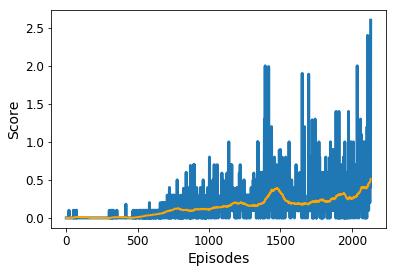

In [6]:
episodes = range(1, len(score_episodes) + 1)
plt.plot(episodes, score_episodes, lw=3)
plt.plot(episodes, mov_avg_score_episodes, lw=2, color='orange')
plt.xlabel('Episodes', fontsize=14)
plt.ylabel('Score', fontsize=14)
plt.xticks(fontsize=12)
_ = plt.yticks(fontsize=12)

Great, hopefully you also managed to train the "agents" without any inconvenient. The progress was slowly and a bit noisy, but it managed to reach the milestone.

## 4. Watch a pair of smart agents

It's time to watch the performance of our autonomous agent

In [7]:
#############################################################
# Agent(s) setup
random_seed = 1701
agent = SADDPG(
    state_size=state_size, action_size=action_size,
    random_seed=random_seed)
agent.load('checkpoint.pth')
#############################################################

for i in range(1, 6):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]
    states = env_info.vector_observations
    scores = np.zeros(num_agents)
    while True:
        actions = agent.act(states)
        env_info = env.step(actions)[brain_name]
        next_states = env_info.vector_observations
        rewards = env_info.rewards
        dones = env_info.local_done
        scores += env_info.rewards
        states = next_states
        if np.any(dones):
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0
Score (max over agents) from episode 2: 0.10000000149011612
Score (max over agents) from episode 3: 0.10000000149011612
Score (max over agents) from episode 4: 0.10000000149011612
Score (max over agents) from episode 5: 1.1000000163912773


When finished, you can close the environment.

## 5. Further explorations

The previous solution corresponds to the 1st iteration to solve the _Tennis_ challenge. The following picture summarizes the learning journey afterwards:

![Comparison](https://github.com/escorciav/drlnd-collab-compet/raw/master/data/plot_comparison.png)

The top-left corner corresponds to the previous solution where a single agent that learns to master the game through self-play. Naturally, the subsequent question is:

_Can we do better?_

The first change that we pursued came from the fact that the learning progress was too slow, and a bit shaky. Around the episode 1500, the agent was progressively learning until its average score suddenly decreases. This suggested that we could tune the rate of change of our network parameters ($\theta_\mu,\theta_Q$). Therefore, we increased the  learning rate (1e-2, 1e-3, 1e-1) for our actor-critic networks. However, this did not work at all. On the other hand, we observed that increasing the update rate of our target network ($\tau$) was extremely benefitial. This simple change allows to reduce the number of episodes required to solve the challenge by **4.3x**. Th evidence of that is depicted in *Figure (b)*.

After exploring the hyper-parameter space a bit, we feel that it was time to consider architectural changes to our solution. In particular,

_Does the addition of multiple agents reduces the numbers of episodes required to solve the challenge?_

The most straigforward solution is to train two independent agents i.e. two pairs of actor-critic networks with different $\theta_\mu,\theta_Q$ parameters.
Interestingly, this approach works out of the shelf and reduces the number of episodes wrt our initial solution. However, it takes roughly **2.8x** more episodes to train than our fastest solution.
Please note that the agents shared the replay buffer as it may introduce more diversity on the mini-batches.

Finally, in the context of multiple agents and actor-critic methods we can consider more interesting variants. For example, sharing the _Critic_ network among different _Actors_. This could be analogous hire the same couch to shape our agents. *Figure (d)* shows the results of this approach. First, it is interesting to note that sharing the _Critic_ network yields a reduction of **2.4x** in the number of episodes to reach the milestone in comparison to two independent _Critics_ (_Figure (c)_ v.s. _Figure (d)_). Overall, the reduction is competitive to our fastest approach, _Figure (b)_, and we observe that the number of episodes may be similar for other seeds.

In case you want to try one of the following solution, feel free to edit the cells above replacing the agent setup enclosed inside the comments with one of the following configurations.

```python
# Fig (b)
# Single-agent
# The fastest trainig
agent = SADDPG(
    state_size=state_size, action_size=action_size,
    random_seed=random_seed, tau=1e-2)

# Fig (c)
# Multi-agent (independent actors and critic)
# Train slower than Fig-b, but faster than previous solution
agent = MiADDPG(
    num_agents=num_agents, state_size=state_size,
    action_size=action_size, random_seed=random_seed,
    tau=1e-2, share_critic=False)

# Fig (d)
# Multi-agent (independent actors, same critic/couch)
# Competitive speed wrt to Fig (b)
agent = MiADDPG(
    num_agents=num_agents, state_size=state_size,
    action_size=action_size, random_seed=random_seed,
    tau=1e-2, share_critic=True)
```

You can find checkpoints of all these agents [here](https://github.com/escorciav/drlnd-collab-compet/raw/master/checkpoints/).

Feel free to dig into the training details of the `SADDPG` and `MiADDPG` abstractions to train a single and multiple agents, respectively. Please share suggestions about how to refactor the code to make it more readable or maintainable.

_Implementation notes_

- Computational complexity and sampling budget of single and multi-agent approaches

  It is unfair and misleading to compare both approaches without disclosing the computational and sampling scheme details of them.
  In our case, the networks were  effectively trained with the same number of examples per mini-batch. Thus, a reduction in the number of episodes to reach the milestone translates into an efficient use of training examples.
  Moreover, all our schemes have an equivalent computational complexity during inference regardless of the implementation details.
  During training, the computational complexity of our multi-agent approach scales linearly with the number of agents and the computational complexity of training a single agent. In other words, if we spend 1s doing a forward-backward pass training a single agent, we would expect to spend 2s for our multi-agent solution.

## 6. Departing words

The main take away from this project is that agents can learn through self-play. Interestingly, we did not require adjustments to the standard DDPG algorithm to solve the _Tennis_ challenge. There are more steps to improve the learning of our autonomous agents. For example:

- Prioritized experience replay. Currently, the past experiences used to train the brain is by sampling uniform random. However, we could argue that some experiences may be more "important" than others. Moreover, it is possible that such "important" experiences are infrequent and our agents ends up sampling them less often. Therefore, it would be ideal to implement a mechanism to sampling experiences in a non-uniform way based on some criterion.

- Noise in the parameteres space. To account for more exploration and possibly more robustness to unseen conditions and states, it would be important to implemente the noise in the parameters strategy dicussed [here](https://blog.openai.com/better-exploration-with-parameter-noise/).

- Multi-agent approaches. It would be interesting to observe if more advanced multi-agent algorithms such as [MADDPG](https://arxiv.org/pdf/1706.02275.pdf) reduces the number of episodes required to achieve the same milestone.